In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

# Linguistic Features

Processing raw text intelligently is difficult: most words are rare, and it’s common for words that look completely different to mean almost the same thing. The same words in a different order can mean something completely different. Even splitting text into useful word-like units can be difficult in many languages. While it’s possible to solve some problems starting from only the raw characters, it’s usually better to use linguistic knowledge to add useful information. That’s exactly what spaCy is designed to do: you put in raw text, and get back a Doc object, that comes with a variety of annotations.

## Part-of-speech tagging

After tokenization, spaCy can parse and tag a given Doc. This is where the trained pipeline and its statistical models come in, which enable spaCy to make predictions of which tag or label most likely applies in this context. A trained component includes binary data that is produced by showing a system enough examples for it to make predictions that generalize across the language – for example, a word following “the” in English is most likely a noun.

Linguistic annotations are available as Token attributes. Like many NLP libraries, spaCy encodes all strings to hash values to reduce memory usage and improve efficiency. So to get the readable string representation of an attribute, we need to add an underscore _ to its name:

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

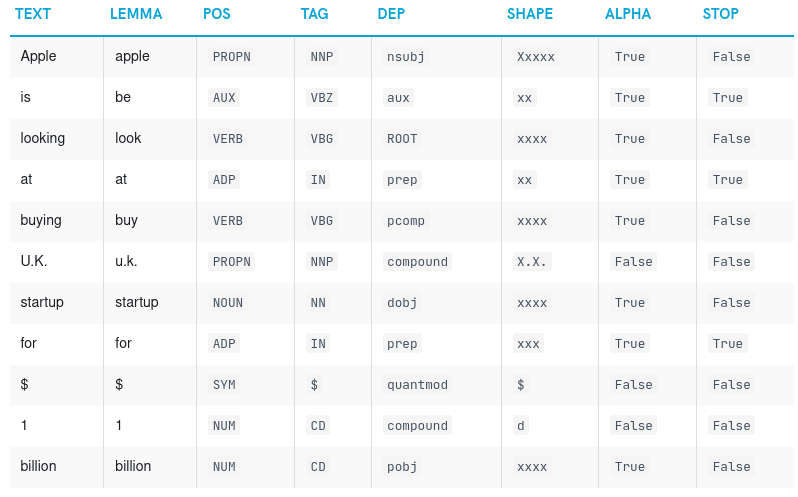

**Text**: The original word text.  
**Lemma**: The base form of the word.  
**POS**: The simple UPOS part-of-speech tag.  
**Tag**: The detailed part-of-speech tag.  
**Dep**: Syntactic dependency, i.e. the relation between tokens.  
**Shape**: The word shape – capitalization, punctuation, digits.  
**is alpha**: Is the token an alpha character?  
**is stop**: Is the token part of a stop list, i.e. the most common words of the language?

Using spaCy’s built-in displaCy visualizer, here’s what our example sentence and its dependencies look like:

In [ ]:
spacy.displacy.render(doc, style="dep")

## Morphology

Inflectional morphology is the process by which a root form of a word is modified by adding prefixes or suffixes that specify its grammatical function but do not change its part-of-speech. We say that a lemma (root form) is inflected (modified/combined) with one or more morphological features to create a surface form. Here are some examples:

|Context | Surface | Lemma | POS | Morphological Features|
|---|---|---|---|---|
|I was reading the paper | reading | read | VERB | VerbForm=Ger|
|I don’t watch the news, I read the paper|read|read|VERB|VerbForm=Fin, Mood=Ind, Tense=Pres|
|I read the paper yesterday|read|read|VERB|VerbForm=Fin, Mood=Ind, Tense=Past|

Morphological features are stored in the MorphAnalysis under Token.morph, which allows you to access individual morphological features.

In [ ]:
print("Pipeline:", nlp.pipe_names)
doc = nlp("I was reading the paper.")
token = doc[0]  # 'I'
print(token.morph)  # 'Case=Nom|Number=Sing|Person=1|PronType=Prs'
print(token.morph.get("PronType"))  # ['Prs']

### Statistical morphology

spaCy’s statistical Morphologizer component assigns the morphological features and coarse-grained part-of-speech tags as Token.morph and Token.pos.

In [ ]:
doc = nlp("Wo bist du?") # English: 'Where are you?'
print(doc[2].morph)  # 'Case=Nom|Number=Sing|Person=2|PronType=Prs'
print(doc[2].pos_) # 'PRON'

### Rule-based morphology

For languages with relatively simple morphological systems like English, spaCy can assign morphological features through a rule-based approach, which uses the token text and fine-grained part-of-speech tags to produce coarse-grained part-of-speech tags and morphological features.

1. The part-of-speech tagger assigns each token a fine-grained part-of-speech tag. In the API, these tags are known as Token.tag. They express the part-of-speech (e.g. verb) and some amount of morphological information, e.g. that the verb is past tense (e.g. VBD for a past tense verb in the Penn Treebank) .
2. For words whose coarse-grained POS is not set by a prior process, a mapping table maps the fine-grained tags to a coarse-grained POS tags and morphological features.

In [ ]:
doc = nlp("Where are you?")
print(doc[2].morph)  # 'Case=Nom|Person=2|PronType=Prs'
print(doc[2].pos_)  # 'PRON'

## Lemmatization

spaCy provides two pipeline components for lemmatization:

1. The Lemmatizer component provides lookup and rule-based lemmatization methods in a configurable component. An individual language can extend the Lemmatizer as part of its language data.
2. The EditTreeLemmatizer component provides a trainable lemmatizer.

In [ ]:
lemmatizer = nlp.get_pipe("lemmatizer")
print(lemmatizer.mode)  # 'rule'

doc = nlp("I was reading the paper.")
print([token.lemma_ for token in doc])
# ['I', 'be', 'read', 'the', 'paper', '.']

The data for spaCy’s lemmatizers is distributed in the package spacy-lookups-data. The provided trained pipelines already include all the required tables, but if you are creating new pipelines, you’ll probably want to install spacy-lookups-data to provide the data when the lemmatizer is initialized.

### Lookup lemmatizer

For pipelines without a tagger or morphologizer, a lookup lemmatizer can be added to the pipeline as long as a lookup table is provided, typically through spacy-lookups-data. The lookup lemmatizer looks up the token surface form in the lookup table without reference to the token’s part-of-speech or context.

In [ ]:
nlp = spacy.blank("sv")
nlp.add_pipe("lemmatizer", config={"mode": "lookup"})

### Rule-based lemmatizer

When training pipelines that include a component that assigns part-of-speech tags (a morphologizer or a tagger with a POS mapping), a rule-based lemmatizer can be added using rule tables from spacy-lookups-data:

In [ ]:
nlp = spacy.blank("de")
# Morphologizer (note: model is not yet trained!)
nlp.add_pipe("morphologizer")
# Rule-based lemmatizer
nlp.add_pipe("lemmatizer", config={"mode": "rule"})

The rule-based deterministic lemmatizer maps the surface form to a lemma in light of the previously assigned coarse-grained part-of-speech and morphological information, without consulting the context of the token. The rule-based lemmatizer also accepts list-based exception files. For English, these are acquired from WordNet.

### Trainable lemmatizer

The EditTreeLemmatizer can learn form-to-lemma transformations from a training corpus that includes lemma annotations. This removes the need to write language-specific rules and can (in many cases) provide higher accuracies than lookup and rule-based lemmatizers.

In [ ]:
nlp = spacy.blank("de")
nlp.add_pipe("trainable_lemmatizer", name="lemmatizer")